# Following is the data organization process

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from joblib import dump, load
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(6,4))

<Figure size 600x400 with 0 Axes>

In [3]:
file_path = '/Users/xihuan/Desktop/土壤信息数据集/4.数据整理/prediction/'
file_names = [file for file in os.listdir(file_path) if file.endswith('.xlsx')]
file_names

['clear_datas124.xlsx',
 'clear_datas134.xlsx',
 'clear_datas123.xlsx',
 'Supplementary(6.2晚).xlsx',
 'clear_datas1234.xlsx',
 'clear_datas234.xlsx',
 'Supplementary(6.6晚).xlsx']

lambda: 0.27
time cost： 2.73 min
训练集和测试集的均方误差分别为： 0.58 1.08
训练集和测试集的可决系数分别为： 0.91 0.7


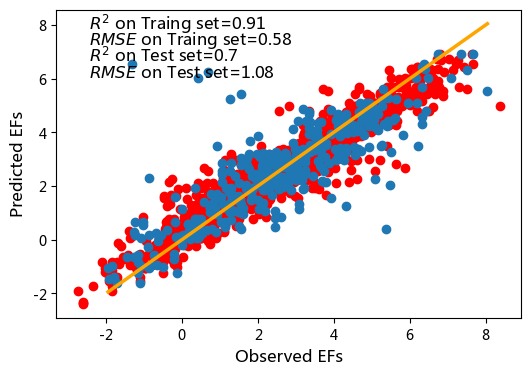

整体的可决系数： 0.9
整体的均方误差为： 0.61
----END----

lambda: 0.26
time cost： 2.76 min
训练集和测试集的均方误差分别为： 0.55 0.93
训练集和测试集的可决系数分别为： 0.91 0.76


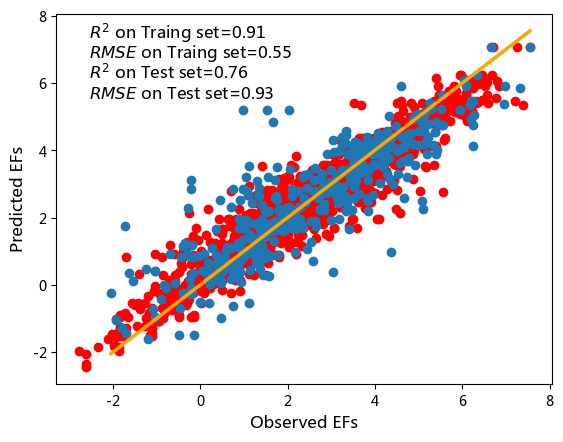

整体的可决系数： 0.91
整体的均方误差为： 0.57
----END----

lambda: 0.29
time cost： 2.39 min
训练集和测试集的均方误差分别为： 0.54 0.86
训练集和测试集的可决系数分别为： 0.92 0.81


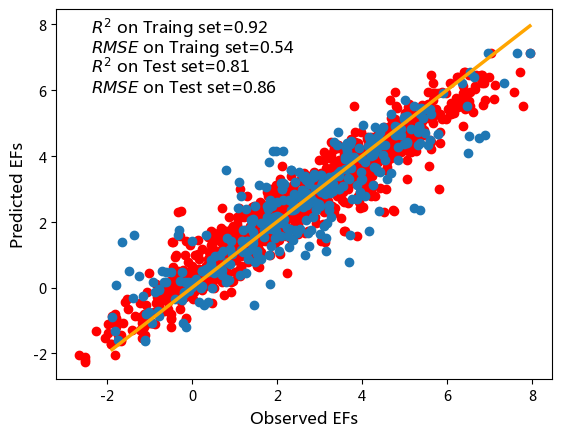

整体的可决系数： 0.92
整体的均方误差为： 0.55
----END----

lambda: 0.25
time cost： 3.51 min
训练集和测试集的均方误差分别为： 0.59 1.0
训练集和测试集的可决系数分别为： 0.9 0.68


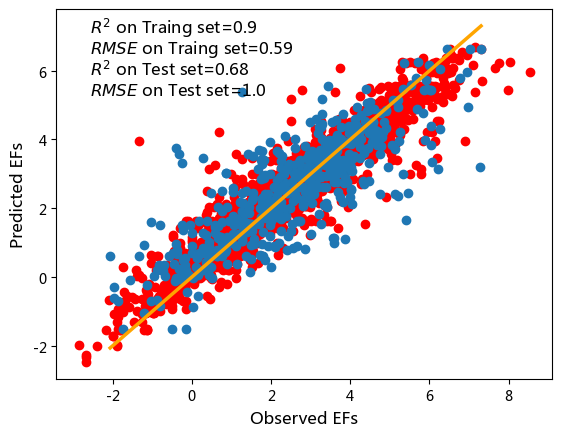

整体的可决系数： 0.9
整体的均方误差为： 0.59
----END----

lambda: 0.28
time cost： 2.36 min
训练集和测试集的均方误差分别为： 0.52 0.9
训练集和测试集的可决系数分别为： 0.93 0.79


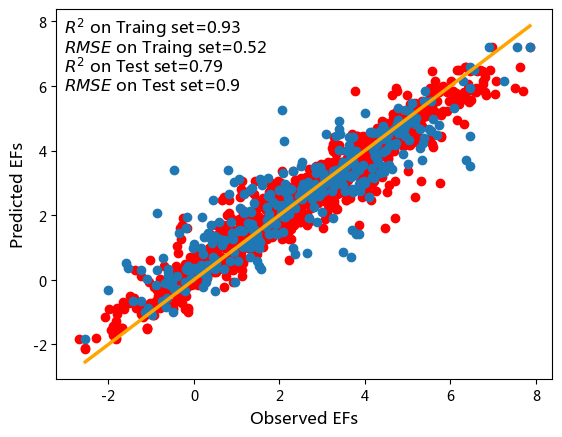

整体的可决系数： 0.93
整体的均方误差为： 0.52
----END----

lambda: 0.26
time cost： 2.62 min
训练集和测试集的均方误差分别为： 0.51 0.99
训练集和测试集的可决系数分别为： 0.93 0.73


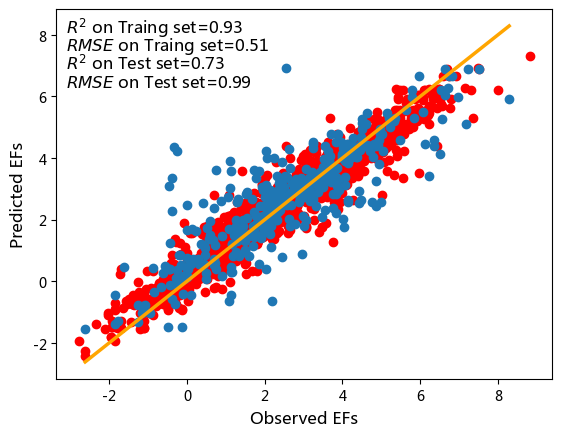

整体的可决系数： 0.92
整体的均方误差为： 0.54
----END----

lambda: 0.25
time cost： 3.46 min
训练集和测试集的均方误差分别为： 0.59 1.02
训练集和测试集的可决系数分别为： 0.9 0.69


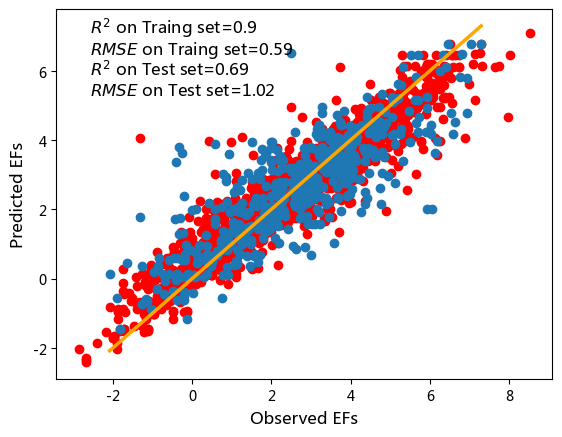

整体的可决系数： 0.89
整体的均方误差为： 0.61
----END----



In [3]:
for filename in file_names:
    #读取数据
    # filename = 'clear_datas1234.xlsx'
    nh3 = pd.read_excel(file_path+filename, sheet_name=0)
    
    
    #将分类变量、数值变量名称分隔开，便于后续数据处理
    col_used = nh3.columns[6:]
    col_categorical = ['Fertilizer type', 'Nitrogen placement', 'Soil tillage practices', 'Crop type']
    col_numerical = list(set(col_used)-set(col_categorical))
    
    
    #现将分类变量进行热码处理，然后再拼接上数值型变量，顺序不能变
    df1 = pd.get_dummies(nh3[col_categorical]).astype(np.int64)
    df1[col_numerical] = nh3[col_numerical]
    
    
    #处理施肥次数作为肥料管理策略实施的依据    
    df1['Fertilizer application time'] = [1 if x >= 2 else 0 for x in df1['Fertilizer application time']]
    
    
    #简化变量名称
    new_names = {'Fertilizer type_AN': 'Ftype(AN)',
                 'Fertilizer type_EEF, controlled-release fertilizers': 'Ftype(CRF)',
                 'Fertilizer type_EEF, double inhibitors': 'Ftype(DI)',
                 'Fertilizer type_EEF, double inhibitors and controlled-release fertilizers': 'Ftype(DICR)',
                 'Fertilizer type_EEF, nitrification inhibitors': 'Ftype(NI)',
                 'Fertilizer type_EEF, urease inhibitors': 'Ftype(UI)',
                 'Fertilizer type_Manure': 'Ftype(Manure)',
                 'Fertilizer type_Others': 'Ftype(Others)',
                 'Fertilizer type_U': 'Ftype(U)',
                 'Nitrogen placement_DPM': 'NP(DPM)',
                 'Nitrogen placement_Mix': 'NP(Mix)',
                 'Nitrogen placement_SBC': 'NP(SBC)',
                 'Soil tillage practices_CT': 'STP(CT)',
                 'Soil tillage practices_NT': 'STP(NT)',
                 'Crop type_Maize': 'Ctype(Maize)',
                 'Crop type_Rice': 'Ctype(Rice)',
                 'Crop type_Wheat': 'Ctype(Wheat)',
                 'Fertilizer application time': 'FAT',
                 'CEC': 'CEC',
                 'Clay': 'Clay',
                 'pH': 'pH',
                 'TN': 'TN',
                 'BD': 'BD',
                 'Erate': 'Erate',
                 'Erate_0': 'Erate_0',
                 'SOC': 'SOC',
                 'Water input': 'Water input',
                 'Nrate': 'Nrate',
                 'Tem': 'Tem',
                 'EF': 'EF',
                 'Replicates': 'Replicates'}
    
    df1.rename(columns=new_names, inplace=True)
    
    #将管理的5种化肥合成1种
    
    df1['Ftype(EEF)'] = df1[['Ftype(CRF)', 'Ftype(DI)', 'Ftype(DICR)', 'Ftype(NI)','Ftype(UI)']].sum(axis=1)
    
    #将目标变量进行BOX-COX变换使其接近正态分布
    from sklearn import preprocessing
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
    df1['EFs'] = pt.fit_transform(100*df1['EF'].to_numpy().reshape(-1, 1)) #将数据整理成1列 
    
    #查看BOX-COX变换中的参数lambda
    print(f'lambda: {round(pt.lambdas_[0],2)}')
    
    #随机打乱样本顺序
    import sklearn
    df = sklearn.utils.shuffle(df1, random_state=2022)  #随机排列整理好的数据
    
    #获取特征变量和目标变量
    Y = df['EFs'].values.reshape(len(df),1)
    X = df.drop(['EFs', 'Replicates', 'EF', 'Nrate', 'Erate_0', 'Erate', 'Ftype(CRF)', 'Ftype(DI)', 'Ftype(DICR)', 'Ftype(NI)','Ftype(UI)'], axis=1)
    
    #划分训练集和测试集
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2022, shuffle=False)
    
    #设置初始参数
    n_estimators = range(100,101)
    # n_estimators = [30,50,100,150]
    random_state = range(2023,2024)
    max_features = range(1,X.shape[1])
    min_samples_leaf = range(1,5)
    max_depth = [3, 5, 8, 10, 15, 20, 25, 30, 35, 40, None] 
    
    param_grid = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'random_state': random_state,
                  'min_samples_leaf': min_samples_leaf,
                  'max_depth': max_depth}
    
    #设置随机森林模型结构
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    grid = GridSearchCV(RandomForestRegressor(), 
                        param_grid, cv=10, n_jobs=-1, 
                        return_train_score=False)
    
    #计时
    from time import *
    begin_time = time()
    
    #拟合随机森林模型
    grid.fit(x_train, y_train.ravel())
    
    #计算程序运行时间
    end_time = time()
    run_time = end_time-begin_time
    print('time cost：', round(run_time/60,2), 'min') 
    
    
    #模型预测
    y_pred_train = grid.predict(x_train)
    y_pred_test = grid.predict(x_test)
    
    #模型评估
    from sklearn.metrics import mean_squared_error, r2_score
    mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print("训练集和测试集的均方误差分别为：", round(mse_train,2), round(mse_test,2))
    print("训练集和测试集的可决系数分别为：", round(r2_train,2), round(r2_test,2))
    
    #绘图
    
    colors = 'r'
    plt.scatter(y_train, y_pred_train, c=colors, label='Traing set'+' (n='+str(len(y_train))+')')
    plt.scatter(y_test, y_pred_test, label='Test set'+' (n='+str(len(y_test))+')')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linewidth=2.5 , c="orange")
    
    plt.text(min(y_test)-0.5, max(max(y_test),max(y_pred_test))-0.2, '$R^{2}$ on Traing set='+str(round(r2_train,2)), fontsize=12)
    plt.text(min(y_test)-0.5, max(max(y_test),max(y_pred_test))-0.8, '$RMSE$ on Traing set='+str(round(mse_train,2)), fontsize=12)
    plt.text(min(y_test)-0.5, max(max(y_test),max(y_pred_test))-1.4, '$R^{2}$ on Test set='+str(round(r2_test,2)), fontsize=12)
    plt.text(min(y_test)-0.5, max(max(y_test),max(y_pred_test))-2, '$RMSE$ on Test set='+str(round(mse_test,2)), fontsize=12)
    
    #plt.legend(loc='lower right', edgecolor='black',fontsize=12)
    # 坐标轴
    plt.xlabel('Observed EFs', fontsize=12)
    plt.ylabel('Predicted EFs', fontsize=12)
    #plt.title('RandomForest Regression', fontsize=12)
    #plt.savefig('./结果汇总/RandomForest_regression.svg')
    
    plt.show()
    
    
    #合并训练集和测试集数据，并用最优随机森林参数重新训练得到最终模型
    RF1 = RandomForestRegressor(**grid.best_params_, oob_score = True)
    RF1.fit(X, Y.ravel())
    
    EFs_pred = RF1.predict(X)
    
    r2 = r2_score(Y, EFs_pred)
    mse = np.sqrt(mean_squared_error(Y, EFs_pred))
    
    print("整体的可决系数：", round(r2,2))
    print("整体的均方误差为：", round(mse,2))
    
    ## 将df['EF']的预测值进行Box-Cox逆变换
    EF_pred = pt.inverse_transform(EFs_pred.reshape(-1, 1)).ravel()
    
    # 储存pt、模型及其变量对象到文件
    dump(pt, f"./save_file/pt_transformer({filename.rsplit('.',1)[0]}).joblib") 
    dump(RF1, f"./save_file/random_forest_model({filename.rsplit('.',1)[0]}).joblib")
    dump(X.columns, f"./save_file/x_columns({filename.rsplit('.',1)[0]}).joblib")
    print('----END----\n')